In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import RMSprop
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import random

In [0]:
os.chdir('/content/gdrive/My Drive/thesis')

In [0]:
data = pd.read_pickle('master_dataset_24112019.pkl')
data = data.dropna(how='any', axis=0)

In [0]:
rf1 = pd.read_pickle('rf+1.pickle')
rf2 = pd.read_pickle('rf+24.pickle')

In [0]:
r1 = rf1.predict(data)
r2 = rf2.predict(data)

In [0]:
r1_df = pd.DataFrame(r1, index=data.index, columns=['pred_+1'])
r2_df = pd.DataFrame(r2, index=data.index, columns=['pred_+24'])

In [0]:
data = pd.concat([data, r1_df, r2_df], axis=1)

In [0]:
target = pd.DataFrame()
target['1_h'] = data['dk2'].shift(-1)
target['24_h'] = data['dk2'].shift(-24)
features = data.iloc[0: -24, :]

In [0]:
target = target[:-24]

In [0]:
target_fitter = target

In [0]:
qs = [-100]
for i in range(1, 101):
  q = i
  qs.append(np.percentile(target_fitter, q))

In [0]:
new_feature = features['dk2'].copy()

In [0]:
new_feature = pd.DataFrame(new_feature, index=target.index)
new_feature.columns = ['price']

In [0]:
def is_in_range(x, lower, upper, val):
  if lower < x <= upper:
    return val
  else:
    return 0

In [0]:
def is_in_range(x, lower, upper, val):
  if lower < x <= upper:
    return val
  else:
    return 0

In [0]:
ss = dict()
for i, (lower, upper) in enumerate(zip(qs[:-1], qs[1:])):
  print(lower, upper)
  s = new_feature['price'].apply(lambda row: is_in_range(row, lower, upper, i))
  ss[i] = s

-100 24.4
24.4 57.4524
57.4524 72.76
72.76 84.95
84.95 97.53
97.53 111.78
111.78 123.12
123.12 133.78
133.78 141.87
141.87 148.28
148.28 152.67
152.67 157.3272
157.3272 161.61
161.61 165.34
165.34 169.34
169.34 173.32
173.32 176.85540000000003
176.85540000000003 179.77
179.77 182.8639
182.8639 185.64
185.64 187.8201
187.8201 190.7782
190.7782 193.67
193.67 196.25439999999998
196.25439999999998 199.3
199.3 201.75119999999995
201.75119999999995 204.74
204.74 207.46999999999997
207.46999999999997 209.55
209.55 211.87
211.87 214.13
214.13 216.04
216.04 217.86
217.86 219.73
219.73 221.53999999999996
221.53999999999996 223.22159999999994
223.22159999999994 224.68
224.68 226.44
226.44 228.38
228.38 230.04
230.04 231.54
231.54 233.52
233.52 235.28999999999996
235.28999999999996 237.23
237.23 238.81
238.81 240.56
240.56 242.56
242.56 244.62
244.62 246.24
246.24 248.33
248.33 250.7
250.7 252.96
252.96 255.15
255.15 257.87
257.87 260.38
260.38 262.35
262.35 265.1017
265.1017 267.74
267.74 269.937

In [0]:
_df = pd.DataFrame(ss)

In [0]:
features['price_bin'] = _df.sum(axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
features['price_bin'] = _df.sum(axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
imp_mean1 = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean1.fit(features)
imp_features = imp_mean1.transform(features)

In [0]:
import datetime

In [0]:
x_train = features[features.index.date < datetime.date(2012, 1, 1)]
x_test = features[(features.index.date >= datetime.date(2015, 1, 1)) & (features.index.date < datetime.date(2017, 1, 1))]

try:
  y_train = target[target.index.date < datetime.date(2012, 1, 1)]
  y_test = target[(target.index.date >= datetime.date(2015, 1, 1)) & (target.index.date < datetime.date(2017, 1, 1))]
except:
  y_train = target_fitter[target.index.date < datetime.date(2012, 1, 1)]
  y_test = target_fitter[(target.index.date >= datetime.date(2015, 1, 1)) & (target.index.date < datetime.date(2017, 1, 1))]

In [0]:
num_train = len(x_train)
num_test = len(x_test)

In [0]:
x_train = imp_mean1.transform(x_train)
x_test = imp_mean1.transform(x_test)

In [0]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [0]:
x_test_scaled = x_scaler.transform(x_test)

In [0]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training data
    """
    
    num_x_signals = features.shape[1]
    num_y_signals = 2
    
    # infinite loop
    while True:
        # Allocate a new array for the batch of input signals
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)
        
        # Allocate a new array for the batch of output signals 
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        
        # Fill the batch with random sequences of data
        for i in range(batch_size):
            # Get a random start_index
            # This points somewhere in the training data
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequence of data starting from this index
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
            
        yield (x_batch, y_batch)

In [0]:
batch_size = 256
sequence_length = 24 * 7 * 4

In [0]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [0]:
x_batch, y_batch = next(generator)

In [0]:
x_batch.shape ,y_batch.shape

((256, 672, 36), (256, 672, 2))

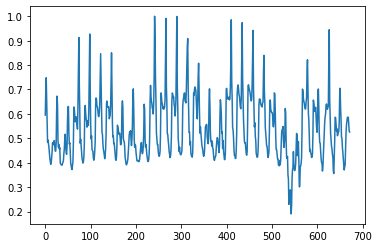

In [0]:
batch = 0 
signal = 0
seq = x_batch[batch , : , signal]
plt.plot(seq)

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [0]:
MODEL_NAME = '1+24+pred_2011'

In [0]:
model = Sequential()
model.add(LSTM(units=100,
               input_shape=(None, x_train.shape[1],),
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=30,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=20,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))

model.add(Dense(y_train.shape[1], activation='relu'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
warmup_steps = 30

In [0]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the mean squared error between y_true and y_pred but ignores the warmup-period of the sequence,
    as there is not yet enough data to make serious predictions.
    """
    
    # The shape of both input tensors are 
    # (batch_size, sequence_length, num_y_signals)
    
    # Ignore the warm-up period by taking slices of the tensors
    y_true_slice = y_true[: , warmup_steps: , :]
    y_pred_slice = y_pred[: , warmup_steps: , :]
    
    # The sliced tensors have the shape (batch_size, sequence_length - warmup_length, num_y_signals)
    
    # Calculate the MSE loss for each value pair
    #loss = tf.losses.mean_squared_error(y_true_slice, y_pred_slice)
    #loss = tf.losses.softmax_cross_entropy(y_true_slice, y_pred_slice)
    loss = tf.keras.losses.MSLE(y_true_slice, y_pred_slice)
    loss_mean = tf.reduce_mean(loss)
    
    return loss_mean

In [0]:
optimizer = RMSprop(lr=1e-3)

In [0]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [0]:
path_checkpoint = f'/content/gdrive/My Drive/thesis/{MODEL_NAME}.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=2,
                                       verbose=1)

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5,
                                        verbose=1)

callback_tensorboard = TensorBoard(log_dir=f'/content/gdrive/My Drive/thesis/',
                                   histogram_freq=0,
                                   write_graph=False)

In [0]:
model.fit_generator(generator=generator,
                    epochs=60,
                    steps_per_epoch=50,
                    validation_data=validation_data,
                    callbacks=[callback_checkpoint, callback_reduce_lr, callback_early_stopping, callback_tensorboard])

Epoch 1/60
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 1/50 [..............................] - ETA: 5:07 - loss: 0.0608
Epoch 00001: val_loss improved from inf to 0.06079, saving model to /content/gdrive/My Drive/thesis/1+24+pred_2011.keras
50/50 [==============================] - 317s 6s/step - loss: 0.0122 - val_loss: 0.0608
Epoch 2/60
 1/50 [..............................] - ETA: 4:47 - loss: 0.0584
Epoch 00002: val_loss improved from 0.06079 to 0.05843, saving model to /content/gdrive/My Drive/thesis/1+24+pred_2011.keras
50/50 [==============================] - 305s 6s/step - loss: 0.0058 - val_loss: 0.0584
Epoch 3/60
 1/50 [..............................] - ETA: 4:55 - loss: 0.0543
Epoch 00003: val_loss improved from 0.05843 to 0.05430, saving model to /content/gdrive/My Drive/thesis/1+24+pred_2011.keras
50/50 [==============================] - 315s 6s/step - loss: 0.0044 - val_loss: 0.0543
Epoch 4/60
 1/50 [......................